In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from natsort import natsort_keygen

In [10]:
# Prepare snps of interest data
snp = pd.read_csv("cauris.snps.of.interest.tsv", sep = "\t", header = 0)
# Rename scaffold 
scaffold = snp["CHROM"].str.split(".", n = 1, expand = True)
snp["CHROM"] = scaffold[0]
snp

,CHROM,POS,REF,ALT,QUAL,FILTER,strain_185,strain_188,strain_189,strain_191,strain_48
0,PEKT02000007,1095126,G,T,794.58,PASS,"1:13,204:217:99:806,0","0:17,0:17:99:0,135","0:7,0:7:99:0,225","0:7,0:7:99:0,256","0:5,0:5:90:0,90"
1,PEKT02000007,3118177,C,G,25870.60,PASS,"1:0,638:638:99:25882,0","0:7,0:7:99:0,236","0:13,0:13:99:0,451","0:9,0:9:99:0,135","0:3,0:3:99:0,126"
2,PEKT02000007,3118730,G,A,30695.60,PASS,"0:5,0:5:99:0,180","0:7,0:7:99:0,236","1:1,868:869:99:30707,0","0:9,0:9:99:0,135","0:3,0:3:99:0,126"
3,PEKT02000010,474991,T,A,629.58,PASS,"0:62,0:62:90:0,90","1:8,72:80:99:641,0","0:44,0:44:90:0,90","0:4,0:4:99:0,135","0:49,0:49:45:0,45"
4,PEKT02000010,804659,T,A,1698.83,PASS,".:60,0:60:0:0,0",".:48,0:48:0:0,0","1:0,51:51:99:1708,0",".:54,0:54:0:0,0","0:7,0:7:23:0,23"
5,PEKT02000002,63940,A,G,551.58,PASS,"0:3,0:3:99:0,129","0:3,0:3:99:0,130","0:3,0:3:99:0,118","0:4,0:4:99:0,116","1:4,205:209:99:563,0"
6,PEKT02000002,63976,A,G,3282.23,PASS,"0:36,35:71:61:0,61","1:5,204:209:99:1933,0","1:6,38:44:99:1365,0","0:94,0:94:55:0,55","0:89,0:89:5:0,5"
7,PEKT02000001,74484,A,T,1390.36,PASS,".:7,15:22:99:149,0",".:4,10:14:99:202,0","1:4,40:44:99:1055,0","0:17,0:37:99:186,741","0:0,0:6:98:98,116"
8,PEKT02000001,743893,G,A,1182.58,PASS,"0:5,0:5:99:0,108","0:4,0:4:99:0,108","1:0,34:34:99:1194,0","0:11,0:11:99:0,336","0:3,0:3:99:0,110"
9,PEKT02000001,790465,A,T,2619.18,PASS,".:5,13:18:99:313,0",".:5,13:21:99:253,0","1:6,27:40:99:654,0","1:12,57:76:99:1415,0","0:1,0:1:3:0,3"


In [11]:
# Function to extract variant depth based on genotype
def get_variant_depth(cell):
    elements = cell.split(":")
    
    if elements[0] == "0":
        return 0
    elif elements[0] == ".":
        return pd.NA
    elif elements[0] == "1":
        if len(elements) >= 3:
            try:
                return int(elements[2]) - int(elements[1].split(",")[0])
            except ValueError:
                return pd.NA
        else:
            return pd.NA
    else:
        return(":".join(elements[:3]))

In [12]:
# Apply function to each cell
snp.iloc[:, 6:] = snp.iloc[:, 6:].applymap(get_variant_depth)
snp

,CHROM,POS,REF,ALT,QUAL,FILTER,strain_185,strain_188,strain_189,strain_191,strain_48
0,PEKT02000007,1095126,G,T,794.58,PASS,204,0,0,0,0
1,PEKT02000007,3118177,C,G,25870.60,PASS,638,0,0,0,0
2,PEKT02000007,3118730,G,A,30695.60,PASS,0,0,868,0,0
3,PEKT02000010,474991,T,A,629.58,PASS,0,72,0,0,0
4,PEKT02000010,804659,T,A,1698.83,PASS,<NA>,<NA>,51,<NA>,0
5,PEKT02000002,63940,A,G,551.58,PASS,0,0,0,0,205
6,PEKT02000002,63976,A,G,3282.23,PASS,0,204,38,0,0
7,PEKT02000001,74484,A,T,1390.36,PASS,<NA>,<NA>,40,0,0
8,PEKT02000001,743893,G,A,1182.58,PASS,0,0,34,0,0
9,PEKT02000001,790465,A,T,2619.18,PASS,<NA>,<NA>,34,64,0


In [13]:
# Concat "CHROM" and "POS" columns together and drop unnecssary columns
snp["CHR_POS"] = snp["CHROM"].str.cat(snp["POS"].astype(str), sep=":")
snp_strain = snp.drop(labels = ["CHROM", "POS", "REF", "ALT", "QUAL", "FILTER"], axis = 1)
# Set "CHR_POS" column to be the new index
snp_strain.set_index("CHR_POS", inplace=True)

In [14]:
def genotype_label(cell):
    if pd.isna(cell):
        return "."
    elif cell > 0:
        return 1
    elif cell == 0:
        return 0
    else:
        return cell

In [15]:
# Covert all values to numeric for compatible with heatmap plot
snp_of_strain_df = snp_strain.apply(pd.to_numeric)
columns = {
    "strain_185": "185-R",
    "strain_188": "188-S",
    "strain_189": "189-R",
    "strain_191": "191-I",
    "strain_48": "WT-S"
}
# Rename sample inlucding phenotype and rerrange based on matching phenotype
snp_of_strain_df.rename(columns = columns, inplace = True)
snp_of_strain_df = snp_of_strain_df.reindex(columns = ["185-R", "189-R", "191-I", "188-S", "WT-S"])
# Reorder scaffold
snp_of_strain_df.sort_values(
    by = "CHR_POS",
    key = natsort_keygen(),
    inplace = True
)
print(snp_of_strain_df)
# Labelling appropriate genotype
ann_snp_of_strain_df = snp_of_strain_df.applymap(genotype_label)
print(ann_snp_of_strain_df)

                      185-R  189-R  191-I  188-S  WT-S
CHR_POS                                               
PEKT02000001:74484      NaN     40    0.0    NaN     0
PEKT02000001:743893     0.0     34    0.0    0.0     0
PEKT02000001:790465     NaN     34   64.0    NaN     0
PEKT02000002:63940      0.0      0    0.0    0.0   205
PEKT02000002:63976      0.0     38    0.0  204.0     0
PEKT02000007:1095126  204.0      0    0.0    0.0     0
PEKT02000007:3118177  638.0      0    0.0    0.0     0
PEKT02000007:3118730    0.0    868    0.0    0.0     0
PEKT02000010:474991     0.0      0    0.0   72.0     0
PEKT02000010:804659     NaN     51    NaN    NaN     0
                     185-R  189-R 191-I 188-S  WT-S
CHR_POS                                            
PEKT02000001:74484       .      1     0     .     0
PEKT02000001:743893      0      1     0     0     0
PEKT02000001:790465      .      1     1     .     0
PEKT02000002:63940       0      0     0     0     1
PEKT02000002:63976       0  

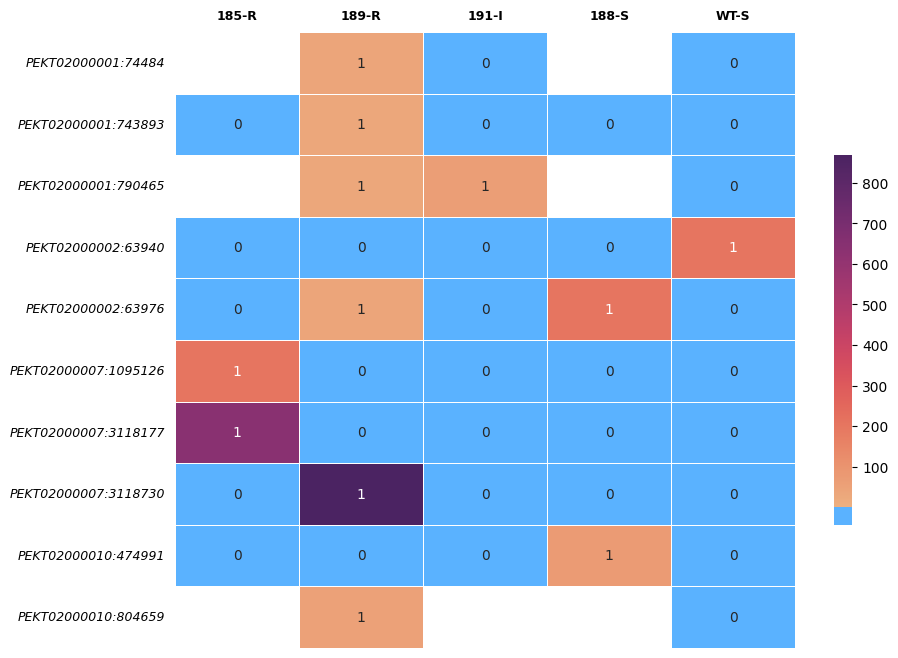

In [19]:
# Heatmap of SNP profile
plt.figure(figsize = (10, 8))
my_cmap = sns.color_palette("flare", as_cmap = True).copy()
my_cmap.set_under("#5AB2FF")
ax = sns.heatmap(snp_of_strain_df, annot = ann_snp_of_strain_df, fmt = "", cmap = my_cmap, square = False,
                 linewidth = 0.5, linecolor = "white", mask = snp_of_strain_df.isnull(),
                 cbar_kws = {"shrink": 0.6, "extend": "min", "extendrect": True},
                 vmin = 0.1
                 )
ax.set(xlabel = "", ylabel = "")
ax.xaxis.tick_top()
plt.xticks(weight = "bold", fontsize = 9, fontfamily = "sans-serif")
plt.yticks(fontsize = 9, fontfamily = "sans-serif", style = "italic")
plt.tick_params(
    axis = "x",
    which = "both",
    top = False
)
plt.tick_params(
    axis = "y",
    which = "both",
    left = False
)
# plt.savefig("snp_heatmap.pdf", format = "pdf", bbox_inches = "tight", dpi = 300)
# plt.savefig("snp_heatmap.png", format = "png", bbox_inches = "tight", dpi = 300)
plt.show()